# Analysis of Scientific Disciplines

### Preparation

#### Load data


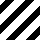
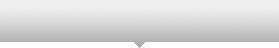
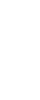
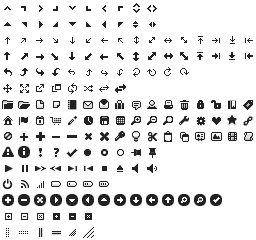
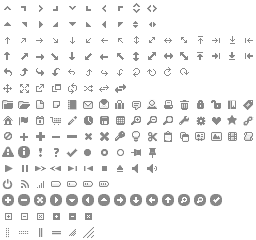
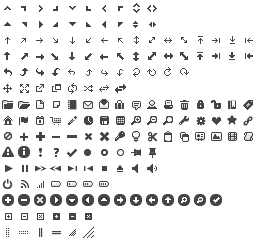
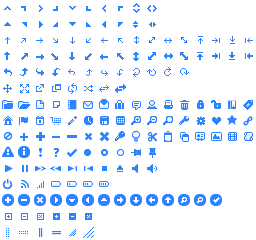
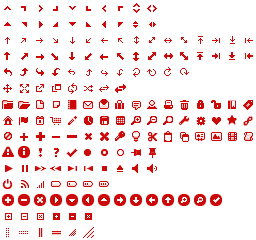
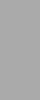
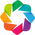
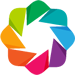
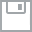
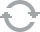
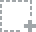
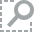
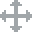
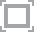
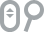

In [1]:
%matplotlib inline
import pylab as plt
import pickle
import random
import numpy as np
from igraph import *
from scipy import stats
import pandas as pd
from collections import Counter
import seaborn as sns
from bokeh.plotting import ColumnDataSource, figure, output_notebook, output_file, show
from bokeh.models import HoverTool
output_notebook()
TOOLS = 'wheel_zoom,pan,reset,save,hover'

In [2]:
classification=pickle.load(open('../BookCodes/top_classifications.pkl'))
print "Classifications loaded. E.g., classification['0887381324']={}".format(classification['0887381324'])
print "How many ISBNs' have Dewey codes: {}".format(Counter([len(classification[x]['dewey'])>0 for x in classification]))
print "How many ISBNs' have LoC codes: {}".format(Counter([len(classification[x]['loc'])>0 for x in classification]))
T_loc=pickle.load(open('../Classifications/loc_tree.pkl'))
T_dd=pickle.load(open('../Classifications/dd_tree.pkl'))
#T_amazon=pickle.load(open('../Classifications/amazon_tree.pkl'))
#g = pickle.load(open('../AmazonBooks/joint_network.pkl','rb'))
g = pickle.load(open('../BarnesNobel/asin_network.pkl','rb'))
print "Co-purchase network loaded: {}".format(g.summary())
#id2isbn=pickle.load(open('../AmazonBooks/id2isbn.pkl','rb'))
#isbn2id=pickle.load(open('../AmazonBooks/isbn2id.pkl','rb'))
#id2topic=pickle.load(open('../AmazonBooks/id2topic.pkl','rb'))
#topic2id=pickle.load(open('../AmazonBooks/topic2id.pkl','rb'))
asin2id = pickle.load(open('../BarnesNobel/asin2id.pkl','r'))
isbn2asin = pickle.load(open('../AmazonBooks/isbn_lookup.pkl'))
asin2isbn=pickle.load(open("../AmazonBooks/asin_lookup.pkl"))

Classifications loaded. E.g., classification['0887381324']={'loc': 'HD9574.E22', 'dewey': '338.2728209866'}
How many ISBNs' have Dewey codes: Counter({True: 1234620, False: 51471})
How many ISBNs' have LoC codes: Counter({True: 1219499, False: 66592})
Co-purchase network loaded: IGRAPH UN-- 439603 3375406 -- 
+ attr: name (v)


#### Populate books into classification trees

In [3]:
import locclass

for t in T_loc.vs:
    t['books']=set()
for t in T_dd.vs:
    t['books']=set()
#for t in T_amazon.vs:
#    t['books']=set()

for isbn in classification:
    #for j in classification[isbn]['dewey']:
    if classification[isbn]['dewey']:
        j=classification[isbn]['dewey']
        code=j.split('.')[0]
        if not code.isdigit():
            continue
        if len(code)>3:
            continue
        t=T_dd.vs.find(code)
        if isbn2asin[isbn] in asin2id:
            t['books'].add(asin2id[isbn2asin[isbn]])
            #t['books'].add(isbn2id[isbn])
    #for code in classification[isbn]['loc']:
    if classification[isbn]['loc']:
        code = classification[isbn]['loc']
        if code:
            topic=locclass.locclass(code)
            t=T_loc.vs.find(topic)
            if isbn2asin[isbn] in asin2id:
                t['books'].add(asin2id[isbn2asin[isbn]])
                #t['books'].add(isbn2id[isbn])

In [4]:
def traverse(T,node,depth):
    T.vs[node]['depth']=depth
    for u in T.neighbors(node,OUT):
        traverse(T,u,depth+1)
        T.vs[node]['books']|= T.vs[u]['books']

In [5]:
#traverse(T_dd,T_dd.vs.find(label='Science').index,1)
#traverse(T_loc,T_loc.vs.find(label='SCIENCE').index,1)
#traverse(T_amazon,T_amazon.vs.find(label='Science&Math').index,1)
traverse(T_dd,0,0)
traverse(T_loc,0,0)
#traverse(T_amazon,0,0)

#### Calculate overlap between trees (not required)

In [ ]:
node1=[]
node2=[]
depth1=[]
depth2=[]
link12=[]
link21=[]
label1=[]
label2=[]
for u in T_dd.vs(depth_gt=1):
    for v in T_loc.vs(depth_gt=1):
        a=len(u['books']&v['books'])
        if a>0:
            node1.append(u['name'])
            label1.append(u['label'])
            depth1.append(u['depth'])
            node2.append(v['name'])
            label2.append(v['label'])
            depth2.append(v['depth'])
            link12.append(1.0*a/len(u['books']))
            link21.append(1.0*a/len(v['books']))
            #print '({}){}\t({}){}\t{}\t{}'.format(u['depth'],u['label'],v['depth'],v['label'],1.0*a/len(u['books']),1.0*a/len(v['books']))

In [ ]:
df=pd.DataFrame({'Dewey':node1,"Label1":label1,"LoC":node2,"Label2":label2,"link12":link12,"link21":link21,"depth1":depth1,"depth2":depth2},
                columns=['Dewey',"Label1","LoC","Label2","link12","link21","depth1","depth2"])

In [ ]:
df[(df.depth1==2) & (df.depth2==2) & ((df.link12>0.1) | (df.link21>0.1))]
    .sort(columns=['Dewey','link12'],ascending=[True,False])
    .to_csv('discipline_align.txt',sep='\t',columns=['Dewey','Label1','LoC','Label2','link12','link21'],index=False)

#### Calculate overlap between disciplines (not required)

In [ ]:
# The input tab delimited file disciplines.txt defines disciplines in terms of Dewey and LoC categories.
def overlap(T1=T_dd,T2=T_loc,filename='disciplines.txt'):
    outfile=open('.'.join(filename.split('.')[:-1])+'_overlap.txt','w')
    infile=open(filename)
    for i,l in enumerate(infile): # in case excel does not use \n to end lines
        if i>0:
            break
    infile.close()
    if i==0:
        infile=l.split('\r')
    else:
        infile=open(filename)
    for l in infile:
        items=l.split('\t')
        if items[0] and (not items[1]) and (not items[2]) and (not items[3]):
            pass
        elif items[0] and (not items[1]) and items[2] and (not items[3]):
            books1=set()
            books2=set()
            discipline=items[0]
        elif items[0] or items[2]:
            code1=items[0]
            code2=items[2]
            if code1:
                try:
                    books1|=T1.vs.find(code1)['books']
                except:
                    print "Cannot find "+code1
            if code2:
                try:
                    books2|=T2.vs.find(code2)['books']
                except:
                    print "Cannot find "+code2
        else:
            a=len(books1&books2)
            if books1 and books2: 
                outfile.write('{}\t{}\t{}\n'.format(discipline,1.0*a/len(books1),1.0*a/len(books2)))
            else:
                outfile.write('{}\t{}\t{}\n'.format(discipline,0,0))
    a=len(books1&books2)
    if books1 and books2: 
        outfile.write('{}\t{}\t{}\n'.format(discipline,1.0*a/len(books1),1.0*a/len(books2)))
    else:
        outfile.write('{}\t{}\t{}\n'.format(discipline,0,0))
    outfile.close()

In [ ]:
overlap(filename='disciplines(03-27).txt')

#### Build the tree of disciplines

In [7]:
def buildTree(filename='disciplines.txt',source='combine'):
    infile=open(filename)
    for i,l in enumerate(infile): # in case excel does not use \n to end lines
        if i>0:
            break
    infile.close()
    if i==0:  
        infile=l.split('\r')
    else:
        infile=open(filename)
    field=None
    discipline=None
    T=Graph(directed=True)
    T.add_vertex(name='Sciences',label='Sciences',depth=0)
    T.vs.find('Sciences')['books']=set()
    for l in infile:
        items=l.split('\t')
        if items[0] and (not items[1]) and (not items[2]) and (not items[3]):
            T.add_vertex(name=items[0],label=items[0],depth=1)
            field=T.vs.find(items[0])
            T.add_edge('Sciences',field)
            field['books']=set()
        elif items[0] and (not items[1]) and items[2] and (not items[3]):
            T.add_vertex(name=items[0],label=items[0],depth=2)
            discipline=T.vs.find(items[0])
            T.add_edge(field,discipline)
            discipline['books']=set()
        elif items[0] or items[2]:
            if items[0] and (source=='dd' or source=='combine'):
                T.add_vertex(name=items[0],label=items[1],depth=3)
                t=T.vs.find(items[0])
                t['books']=T_dd.vs.find(items[0])['books']
                T.add_edge(discipline,t)
            if items[2] and (source=='loc' or source=='combine'):
                T.add_vertex(name=items[2],label=items[3],depth=3)
                t=T.vs.find(items[2])
                t['books']=T_loc.vs.find(items[2])['books']
                T.add_edge(discipline,t)
    return T

In [8]:
disciplineFile='../Disciplines/disciplines(05-13).txt'
D_loc=buildTree(filename=disciplineFile,source='loc')
D_dd=buildTree(filename=disciplineFile,source='dd')
D_com=buildTree(filename=disciplineFile,source='combine')

#### Populate books into disciplines

In [9]:
traverse(D_dd,0,0)
traverse(D_loc,0,0)
traverse(D_com,0,0)

#### Build intersection tree

In [10]:
D_int=D_com.vs(depth_le=2).subgraph()
for v in D_int.vs:
    v['books']=D_loc.vs.find(v['name'])['books'] & D_dd.vs.find(v['name'])['books']

#### Visulaize the tree of disciplines

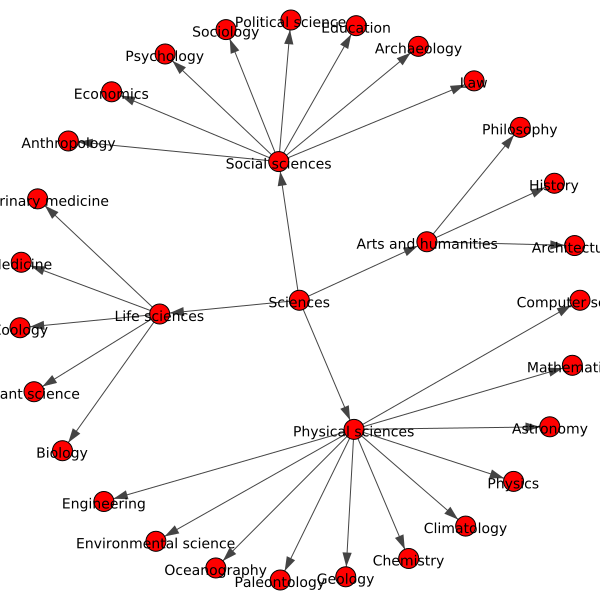

In [11]:
plot(D_loc.vs(depth_le=2).subgraph(),
     layout=D_loc.vs(depth_le=2).subgraph().layout_reingold_tilford_circular(root=0),
     vertex_label=D_loc.vs(depth_le=2)['name'])

#### Map ISBNs to disciplines and subdisciplines 

In [12]:
isbn2disciplineDD=dict()
for discipline in D_dd.vs(depth=2):
    for b in discipline['books']:
        asin=g.vs[b]['name']
        if asin not in isbn2disciplineDD:
            isbn2disciplineDD[asin]=dict()
            isbn2disciplineDD[asin]['discipline']=set()
            isbn2disciplineDD[asin]['subdiscipline']=set()
        isbn2disciplineDD[asin]['discipline'].add(discipline['name'])
        for isbn in asin2isbn[asin]:
            if classification[isbn]:
                if classification[isbn]['dewey']:
                    j=classification[isbn]['dewey']
                    code=j.split('.')[0]
                    if not code.isdigit():
                        continue
                    if len(code)>3:
                        continue
                    t=T_dd.vs.find(code)
                    isbn2disciplineDD[asin]['subdiscipline'].add('{}:{}'.format(t['name'],t['label']))

#asin2discplineDD=isbn2disciplineDD.copy()
#isbn2disciplineDD=dict()
#for asin in asin2discplineDD:
#    for isbn in asin2isbn[asin]:
#        if isbn not in isbn2disciplineDD:
#            isbn2disciplineDD[isbn]=dict()
#            isbn2disciplineDD[isbn]['discipline']=set()
#            isbn2disciplineDD[isbn]['subdiscipline']=set()
#        isbn2disciplineDD[isbn]['discipline']|=asin2discplineDD[asin]['discipline']
#        isbn2disciplineDD[isbn]['subdiscipline']|=asin2discplineDD[asin]['subdiscipline']

In [13]:
isbn2disciplineLOC=dict()
for discipline in D_loc.vs(depth=2):
    for b in discipline['books']:
        asin=g.vs[b]['name']
        if asin not in isbn2disciplineLOC:
            isbn2disciplineLOC[asin]=dict()
            isbn2disciplineLOC[asin]['discipline']=set()
            isbn2disciplineLOC[asin]['subdiscipline']=set()
        isbn2disciplineLOC[asin]['discipline'].add(discipline['name'])
        for isbn in asin2isbn[asin]:
            if classification[isbn]:
                if classification[isbn]['loc']:
                    code = classification[isbn]['loc']
                    if code:
                        topic=locclass.locclass(code)
                        t=T_loc.vs.find(topic)
                    isbn2disciplineLOC[asin]['subdiscipline'].add('{}:{}'.format(t['name'],t['label']))

#asin2discplineLOC=isbn2disciplineLOC.copy()
#isbn2disciplineLOC=dict()
#for asin in asin2discplineLOC:
#    for isbn in asin2isbn[asin]:
#        if isbn not in isbn2disciplineLOC:
#            isbn2disciplineLOC[isbn]=dict()
#            isbn2disciplineLOC[isbn]['discipline']=set()
#            isbn2disciplineLOC[isbn]['subdiscipline']=set()
#        isbn2disciplineLOC[isbn]['discipline']|=asin2discplineLOC[asin]['discipline']
#        isbn2disciplineLOC[isbn]['subdiscipline']|=asin2discplineLOC[asin]['subdiscipline']

###  Books 

#### Calculate alignment of books

In [41]:
liberals=set()
with open('../BookCodes/liberals_6_22.txt') as l:
    for line in l:
        if isbn2asin[line.strip()] in asin2id:
            liberals.add(line.strip())

conservatives=set()
with open('../BookCodes/conservatives_6_22.txt') as c:
    for line in c:
        if isbn2asin[line.strip()] in asin2id:
            conservatives.add(line.strip())
'''
for asin in ['B000B1AAEE','1452605416','B000B1MRGS','B000AHM240','B003O7ZC1S']:
    for isbn in asin2isbn[asin]:
        if isbn in liberals:
            liberals.remove(isbn)
            conservatives.add(isbn)
            print "{}({}) changed from liberal to conservative!".format(isbn,asin)

for asin in ['B005UG52D4','B001JNUOCG','B000B293TQ']:
    for isbn in asin2isbn[asin]:
        if isbn in conservatives:
            conservatives.remove(isbn)
            liberals.add(isbn)
            print "{}({}) changed from conservative to liberal!".format(isbn,asin)
'''
for u in g.vs:
    u['color']=[0,0,0]

for u in liberals:
    g.vs[asin2id[isbn2asin[u]]]['color'][2]=1

for u in conservatives:  
    g.vs[asin2id[isbn2asin[u]]]['color'][0]=1

In [42]:
counter=Counter()
for i in liberals|conservatives:
    if isbn2asin[i] in isbn2disciplineLOC:
        #print isbn2disciplineLOC[isbn2asin[i]]
        counter.update(isbn2disciplineLOC[isbn2asin[i]]['discipline'])

print "Where are the political books: {}".format(counter)

Where are the political books: Counter({'Political science': 458, 'History': 406, 'Law': 30, 'Sociology': 19, 'Economics': 16, 'Philosophy': 7, 'Environmental science': 6, 'Blue': 4, 'Medicine': 3, 'Psychology': 2, 'Engineering': 1, 'Education': 1, 'Climatology': 1})


In [43]:
count=0
for u in g.vs:
    #if count%10000==0:
        #print '{} '.format(count),
    count+=1
    kr=0
    kb=0
    for v in u.neighbors():
        if v['color'][2]==1:
            kb+=1
        if v['color'][0]==1:
            kr+=1
    u['kb']=kb
    u['kr']=kr

d=g.vs(color=[0,0,0])
d=np.add(d['kr'],d['kb'])
Ed=d[d>0].mean()
kr=sum(g.vs(color=[1,0,0]).degree())
kb=sum(g.vs(color=[0,0,1]).degree())
fred=1.0*kr/(kr+kb)
fblue=1.0*kb/(kr+kb)
redness=dict()
count=0
for u in g.vs:
    #if count%10000==0:
        #print '{} '.format(count),
    count+=1
    if u['color']==[0,0,0]:
        kr=u['kr']
        kb=u['kb']
        k=kb+kr
        if k==0:
            continue
        a=Ed*fblue+kb
        b=Ed*fred+kr
        r=b/(a+b)
        if r<=fred:
            r=r/fred*0.5
        else:
            r=(r-fred)/fblue*0.5+0.5
        redness[u.index]=r
        u['color'][0]=r
        u['color'][2]=1-r
    else:
        redness[u.index]=u['color'][0]

#### Consistency of book alignment

In [18]:
blueIndex=[]
redIndex=[]
for u in g.vs:
    if u['color']==[1,0,0]:
        kr=u['kr']
        kb=u['kb']
        k=kb+kr
        if k!=0:
            redIndex.append(u.index)
    elif u['color']==[0,0,1]:
        kr=u['kr']
        kb=u['kb']
        k=kb+kr
        if k!=0:
            blueIndex.append(u.index)

In [19]:
kRed=sum(g.vs(redIndex).degree())
kBlue=sum(g.vs(blueIndex).degree())
kRed*1.0/(kRed+kBlue),fred

(0.6372039942938659, 0.6159018143009605)

In [21]:
ideologyBooks={}
for u in g.vs(list(set(blueIndex) | set(redIndex))):
    kr=u['kr']
    kb=u['kb']
    k=kb+kr
    if k==0:
        ideologyBooks[u['name']]=0
        continue
    a=Ed*fblue+kb
    b=Ed*fred+kr
    r=b/(a+b)
    if r<=fred:
        r=r/fred*0.5
    else:
        r=(r-fred)/fblue*0.5+0.5
    ideologyBooks[u['name']]=r

df=pd.DataFrame({'ASIN':ideologyBooks.keys(),
                 'alignment':ideologyBooks.values(),
                 'ideology':map(lambda x:g.vs.find(x)['color'][0],ideologyBooks.keys()),
                 'k':map(lambda x:g.vs.find(x).degree(),ideologyBooks.keys())})

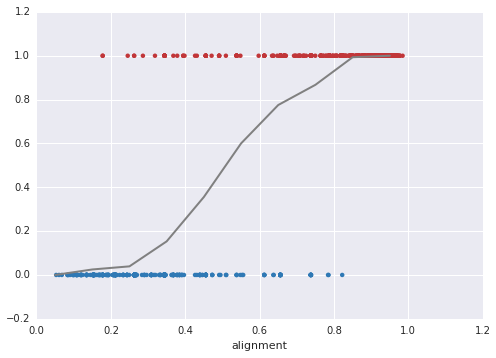

In [22]:
df2=df[df.alignment>0]
xbins=np.arange(0,1.1,0.1)
books,_=np.histogram(df2['alignment'],xbins)
redBooks,_=np.histogram(df2['alignment'],xbins,weights=df2['ideology'])
y=np.zeros_like(redBooks,dtype=float)
y[books!=0]=1.0*redBooks[books!=0]/books[books!=0]
sns.set_palette("RdBu_r")
plt.scatter(df2['alignment'],df2['ideology'],c=map(lambda x: [ 0.18431374,0.47266437,0.71164938] if x==0 else [ 0.75617072, 0.21038063,  0.22352942], df2['ideology']),edgecolors='none')
plt.plot((xbins[1:]+xbins[:-1])/2,y,lw=2,color='grey')
plt.xlabel('alignment')

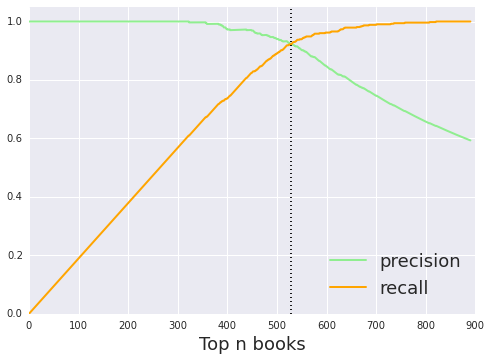

In [23]:
df3=df2[['alignment','ideology']]
total=df3['ideology'].sum()
df3=df3.sort('alignment',ascending=False)
precision=[]
recall=[]
x=range(1,df3.shape[0]+1)
for i in x:
    books=df3['ideology'].iloc[:i].sum()
    precision.append(1.0*books/i)
    recall.append(1.0*books/total)
    
plt.plot(x,precision,color='lightgreen',lw=2)
plt.plot(x,recall,color='orange', lw=2)
plt.plot([total,total],[0,1.05],':',color='k')
plt.ylim([0,1.05])
plt.legend(['precision','recall'],fontsize=18,loc='best')
plt.xlabel('Top n books',fontsize=18)

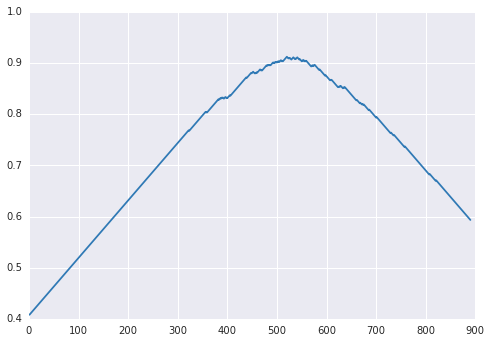

In [24]:
correlation=[]
for i in xrange(1,df3.shape[0]+1):
    imputed=np.zeros_like(df3['ideology'])
    imputed[:i]=1
    #correlation.append(stats.pearsonr(imputed,df3['ideology']))
    correlation.append((imputed==df3['ideology']).sum()*1.0/len(imputed))
plt.plot(xrange(1,df3.shape[0]+1),correlation);

In [33]:
print "Max correlation achieved at cutting at top {} books".format(np.argmax(correlation))
print "If cutting at top 546 books, correlation is {}".format(correlation[526])
print df3.iloc[527]

Max correlation achieved at cutting at top 519 books
If cutting at top 546 books, correlation is 0.908988764045
alignment    0.494663
ideology     0.000000
Name: 91, dtype: float64


### Disciplines

#### Calculate statistics of disciplines and fields

In [34]:
def calculateIdeology(T):
    # Leaves of the tree
    for t in T.vs:
        t['color']=[0,0,0]
        if t['books']:
            t['kr']=sum(g.vs[list(t['books'])]['kr'])
            t['kb']=sum(g.vs[list(t['books'])]['kb'])
        else:
            t['kr']=0
            t['kb']=0

    T2=T.copy()
    T2.vs['out_degree']=T2.degree(mode=OUT)
    d=T2.vs.select(out_degree=0)
    d=np.add(d['kr'],d['kb'])
    Ed=10#np.median(d[d>0])

    for leaf in T2.vs.select(out_degree=0):
        u=T.vs.find(leaf['name'])
        u['size']=len(leaf['books'])
        #u['stdsub']=0
        k=leaf['kb']+leaf['kr']
        a=Ed*fblue+leaf['kb']
        b=Ed*fred+leaf['kr']
        r=b/(a+b)
        if r<=fred:
            r=r/fred*0.5
        else:
            r=(r-fred)/fblue*0.5+0.5
        u['color']=[r,0,1-r]
        u['ci']=[]
        for r in stats.beta.interval(0.9,b,a):
            if r<=fred:
                r=r/fred*0.5
            else:
                r=(r-fred)/fblue*0.5+0.5
            u['ci'].append(r)
        r=[]
        if k>0:
            for b in leaf['books']:
                if b in redness:
                    r.append(redness[b])
            u['polarization']=np.mean(np.maximum(np.array(r),1-np.array(r)))
            books=g.vs(list(leaf['books']))
            kr=np.array(books['kr'])
            kb=np.array(books['kb'])
            u['polarization2']=1.0*sum((kr*kb)>0)/sum((kr+kb)>0)
            #u['std']=np.std(r)
            #u['mean']=np.mean(r)
            #u['skew']=stats.skew(r)
        else:
            u['polarization']=0
            u['polarization2']=0
        u['psize']=len(r)
    T2.delete_vertices(T2.vs.select(out_degree=0))

    # Internal nodes of the tree
    while T2:
        T2.vs['out_degree']=T2.degree(mode=OUT)
        d=T2.vs.select(out_degree=0)
        d=np.add(d['kr'],d['kb'])
        #Ed=np.median(d[d>0])
        for leaf in T2.vs.select(out_degree=0):
            u=T.vs.find(leaf['name'])
            kb=u['kb']
            kr=u['kr']
            #childp=[]
            #for v in T.neighbors(u,OUT):
            #    if sum(T.vs[v]['color']):
            #        childp.append(T.vs[v]['color'][0])
            #if childp:
                #u['stdsub']=np.std(childp)
            k=kb+kr
            u['size']=len(u['books'])
            #u['stdsub']=0
            a=Ed*fblue+kb
            b=Ed*fred+kr
            r=b/(a+b)
            if r<=fred:
                r=r/fred*0.5
            else:
                r=(r-fred)/fblue*0.5+0.5
            u['color']=[r,0,1-r]
            u['ci']=[]
            for r in stats.beta.interval(0.9,b,a):
                if r<=fred:
                    r=r/fred*0.5
                else:
                    r=(r-fred)/fblue*0.5+0.5
                u['ci'].append(r)
            r=[]
            if k>0:
                for b in u['books']:
                    if b in redness:
                        r.append(redness[b])
                #u['std']=np.std(r)
                #u['mean']=np.mean(r)
                #u['skew']=stats.skew(r)
                #u['dist']=np.histogram(r,bins=15)
                u['polarization']=np.mean(np.maximum(np.array(r),1-np.array(r)))
                books=g.vs(list(leaf['books']))
                kr=np.array(books['kr'])
                kb=np.array(books['kb'])
                u['polarization2']=1.0*sum((kr*kb)>0)/sum((kr+kb)>0)
            else:
                u['polarization']=0
                u['polarization2']=0
            u['psize']=len(r)
        T2.delete_vertices(T2.vs.select(out_degree=0))

In [35]:
calculateIdeology(D_com)
calculateIdeology(D_dd)
calculateIdeology(D_loc)
calculateIdeology(D_int)

In [ ]:
pickle.dump(D_int,open('../Disciplines/D_intersect.pkl','wb'))
pickle.dump(D_loc,open('../Disciplines/D_loc.pkl','wb'))
pickle.dump(D_dd,open('../Disciplines/D_dd.pkl','wb'))
pickle.dump(D_com,open('../Disciplines/D_combine.pkl','wb'))

#### Build network of disciplines

In [44]:
G=D_loc.vs(depth=2).subgraph()
G.to_undirected()

isbn2discipline=isbn2disciplineLOC
G.add_vertex('Blue',label='Liberal Books',books=set())
G.add_vertex('Red',label='Conservative Books',books=set())
u=G.vs.find('Blue')
for i in liberals:
    u['books'].add(asin2id[isbn2asin[i]])
    if isbn2asin[i] not in isbn2discipline:
        isbn2discipline[isbn2asin[i]]=dict()
        isbn2discipline[isbn2asin[i]]['discipline']=set()
        isbn2discipline[isbn2asin[i]]['subdiscipline']=set()
    isbn2discipline[isbn2asin[i]]['discipline'].add('Blue')
    isbn2discipline[isbn2asin[i]]['subdiscipline'].add('Blue:Blue')
u=G.vs.find('Red')
for i in conservatives:
    u['books'].add(asin2id[isbn2asin[i]])
    if isbn2asin[i] not in isbn2discipline:
        isbn2discipline[isbn2asin[i]]=dict()
        isbn2discipline[isbn2asin[i]]['discipline']=set()
        isbn2discipline[isbn2asin[i]]['subdiscipline']=set()
    isbn2discipline[isbn2asin[i]]['discipline'].add('Red')
    isbn2discipline[isbn2asin[i]]['subdiscipline'].add('Red:Red')

nodes=set(G.vs['name'])
G.add_edges(( (u['name'],v) for u in G.vs 
             for i in u['books'] 
             for j in g.neighbors(i) 
             if g.vs[j]['name'] in isbn2discipline
             for v in isbn2discipline[g.vs[j]['name']]['discipline']))
G.es['weight']=1.0

G.simplify(multiple=True, loops=True, combine_edges='sum');

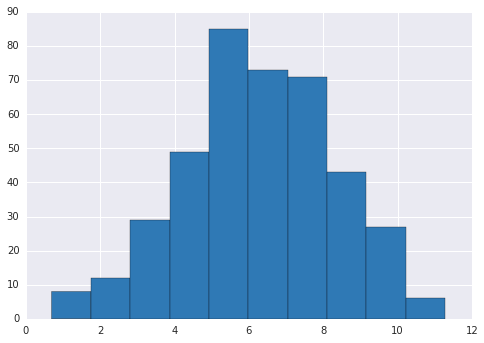

In [45]:
plt.hist(np.log(G.es['weight']));

#### Calculate relevance

In [46]:
G.to_directed()
m=sum(G.es['weight'])
d=np.median(G.es['weight'])*1.0
for e in G.es:
    e['relevance']= (e['weight']+G.vs[e.target].strength(mode='OUT',weights='weight')*d/m)/(G.vs[e.source].strength(mode='OUT',weights='weight')+d)

u=G.vs.find('Red')
u['alignment']=1
u['size']=len(u['books'])
rRed=u.strength(mode='IN',weights='weight')*1.0/m
u=G.vs.find('Blue')
u['alignment']=0
u['size']=len(u['books'])
rBlue=u.strength(mode='IN',weights='weight')*1.0/m

for u in G.vs[:G.vcount()-2]:
    v=D_loc.vs.find(u['name'])
    u['alignment']=v['color'][0]
    u['size']=len(u['books'])
    try:
        eRed=G.get_eid(u.index,G.vs.find('Red').index)
        u['redness']=G.es[eRed]['relevance']
    except:
        u['redness']=d*rRed/(u.strength(mode='OUT',weights='weight')+d)
    try:
        eBlue=G.get_eid(u.index,G.vs.find('Blue').index)
        u['blueness']=G.es[eBlue]['relevance']
    except:
        u['blueness']=d*rBlue/(u.strength(mode='OUT',weights='weight')+d)
    u['relevance']=u['redness']+u['blueness']
    v['relevance']=u['relevance']

In [47]:
if False:
    fig, ax = plt.subplots()
    ax.plot(G.vs[:G.vcount()-2]['redness'],G.vs[:G.vcount()-2]['blueness'],'o')
    ax.plot([rRed,rRed],[0,0.03],'c--')
    ax.plot([0,0.06],[rBlue,rBlue],'c--')
    ax.plot([0,0.06],[0,rBlue/rRed*0.06],'w')
    for u in G.vs[:G.vcount()-2]:
        if u['redness']>rRed or u['blueness']>rBlue:
            ax.annotate(u['label'],(u['redness'],u['blueness']))
    ax.set_xlabel('co-purchase with red')
    ax.set_ylabel('co-purchese with blue')
else:
    source = ColumnDataSource(
        data=dict(
            x=G.vs[:G.vcount()-2]['redness'],
            y=G.vs[:G.vcount()-2]['blueness'],
            name=G.vs[:G.vcount()-2]['label']
        )
    )

    fig = figure(plot_height=500,x_range=[0,0.045],y_range=[0,0.02],x_axis_label='co-purchase with red', y_axis_label='co-purchese with blue',tools=TOOLS)
    p=fig.scatter('x','y',size=10,source=source,name='points')
    hover=p.select(dict(type=HoverTool))
    hover.tooltips = '<div><span style="font-size: 15px;">@name</span></div>'
    hover.names=['points']
    fig.line([rRed,rRed],[0,0.02],line_dash=[3,3])
    fig.line([0,0.05],[rBlue,rBlue],line_dash=[3,3])
    fig.line([0,0.05],[0,rBlue/rRed*0.05],line_dash=[3,3])
    show(p)

In [38]:
G2=G.copy()
G2.to_undirected(combine_edges='mean')
G2.vs['relevance']=np.append(relevance,[relevance.max(),relevance.max()])*50
G2.vs['alignment']=np.array(G2.vs['alignment'])*500
G2.vs['B']=1-np.array(G2.vs['alignment'])
G2.vs['G']=0
G2.write_gml('../Disciplines/disciplineNetworkJoint.gml')

/home/ubuntu/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: RuntimeWarning: A non-numeric, non-string, non-boolean edge attribute was ignored at foreign.c:2648


#### Build network of subdisciplines

In [98]:
G=D_loc.vs(depth=3).subgraph()
G.to_undirected()

isbn2discipline=isbn2disciplineLOC
G.add_vertex('Blue',label='Liberal Books',books=set())
G.add_vertex('Red',label='Conservative Books',books=set())
u=G.vs.find('Blue')
for i in liberals:
    u['books'].add(asin2id[isbn2asin[i]])
    if isbn2asin[i] not in isbn2discipline:
        isbn2discipline[isbn2asin[i]]=dict()
        isbn2discipline[isbn2asin[i]]['discipline']=set()
        isbn2discipline[isbn2asin[i]]['subdiscipline']=set()
    isbn2discipline[isbn2asin[i]]['discipline'].add('Blue')
    isbn2discipline[isbn2asin[i]]['subdiscipline'].add('Blue:Blue')
u=G.vs.find('Red')
for i in conservatives:
    u['books'].add(asin2id[isbn2asin[i]])
    if isbn2asin[i] not in isbn2discipline:
        isbn2discipline[isbn2asin[i]]=dict()
        isbn2discipline[isbn2asin[i]]['discipline']=set()
        isbn2discipline[isbn2asin[i]]['subdiscipline']=set()
    isbn2discipline[isbn2asin[i]]['discipline'].add('Red')
    isbn2discipline[isbn2asin[i]]['subdiscipline'].add('Red:Red')

nodes=set(G.vs['name'])
G.add_edges(( (u['name'],v.split(':')[0]) for u in G.vs 
             for i in u['books'] 
             for j in g.neighbors(i) 
             if g.vs[j]['name'] in isbn2discipline
             for v in isbn2discipline[g.vs[j]['name']]['subdiscipline']
             if v.split(':')[0] in nodes))
G.es['weight']=1.0

G.simplify(multiple=True, loops=True, combine_edges='sum');

#### Calculate relevance for subdisciplines

In [99]:
m=sum(G.es['weight'])*2.0
rRed=G.vs.find('Red').strength(weights='weight')/m
rBlue=G.vs.find('Blue').strength(weights='weight')/m
d=m/G.vcount()
for u in G.vs[:G.vcount()-2]:
    v=D_loc.vs.find(u['name'])
    u['alignment']=v['color'][0]
    if not u['kr']:
        u['kr']=0
    if not u['kb']:
        u['kb']=0
    u['relevance']=(d*(rRed+rBlue)+u['kr']+u['kb'])/(d+u.strength(weights='weight'))
    u['size']=len(u['books'])
    v['relevance']=u['relevance']

u=G.vs.find('Red')
u['alignment']=1
u['size']=len(u['books'])
u=G.vs.find('Blue')
u['alignment']=0
u['size']=len(u['books'])

In [103]:
relevance=np.log(np.array(G.vs[:G.vcount()-2]['relevance']))
if False:
    fig,ax=plt.subplots()
    ax.scatter((G.vs[:G.vcount()-2]['alignment']),
                relevance,
                s=np.square(np.log(G.vs[:G.vcount()-2]['size'])),
                c=G.vs[:G.vcount()-2]['color'])
else:
    source = ColumnDataSource(
        data=dict(
            x=G.vs[:G.vcount()-2]['alignment'],
            y=relevance,
            name=G.vs[:G.vcount()-2]['label']
        )
    )

    fig = figure(x_axis_label='alignment', y_axis_label='relevance',tools=TOOLS,toolbar_location="right")
    p=fig.scatter('x','y',size=np.log(G.vs[:G.vcount()-2]['size']),source=source,name='points')
    hover=p.select(dict(type=HoverTool))
    hover.tooltips = '<div><span style="font-size: 15px;">@name</span></div>'
    show(p)

In [74]:
df=pd.DataFrame({'relevance':G.vs[:G.vcount()-2]['relevance'],
                 'alignment':G.vs[:G.vcount()-2]['alignment'],
                 'name':G.vs[:G.vcount()-2]['label']})

In [102]:
df=df.sort('alignment',ascending=False)[:100]

(-50, 1)

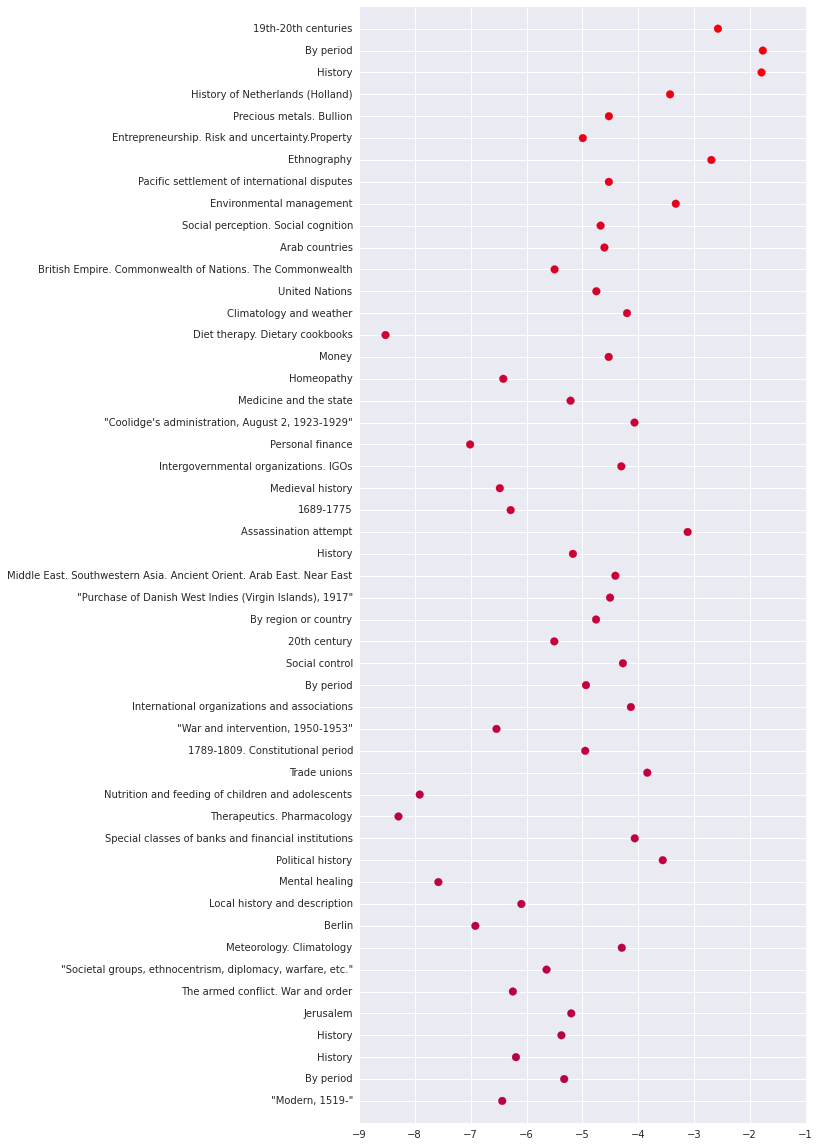

In [103]:
fig=plt.figure(figsize=[8,20])
ax=fig.add_subplot(111)
ax.scatter(np.log(df['relevance']),-np.arange(len(df['alignment'])),s=60,color=np.vstack([df['alignment'],np.zeros_like(df['alignment']),1-np.array(df['alignment'])]).T)
#ax.plot([0.5,0.5],[0,-len(ideology)],'k--')
_=plt.yticks(-np.arange(len(df['alignment'])), list(df['name']), fontsize=10);
#ax.set_xlim([0,1])
ax.set_ylim([-len(df['alignment']),1])
#plt.tight_layout()

### Relevance

#### Number of politically relavant books in disciplines

In [48]:
df=pd.DataFrame({"Discipline":D_int.vs['name'],
                 "Combined":[D_com.vs.find(i['name'])['psize'] for i in D_int.vs],
                 "Intersect":[D_int.vs.find(i['name'])['psize'] for i in D_int.vs],
                 "Dewey":[D_dd.vs.find(i['name'])['psize'] for i in D_int.vs],
                 "LoC":[D_loc.vs.find(i['name'])['psize'] for i in D_int.vs],
                 "ratio":1.0*np.array([D_loc.vs.find(i['name'])['psize'] for i in D_int.vs])/np.array([D_loc.vs.find(i['name'])['size'] for i in D_int.vs]),
                 "Level":D_int.vs['depth']},
                 columns=["Discipline","Dewey","LoC","ratio","Combined","Intersect","Level"])
print df.to_string(index=False)

            Discipline  Dewey   LoC     ratio  Combined  Intersect  Level
              Sciences   8998  8927  0.036743     10639       7286      0
     Physical sciences    180   253  0.005254       304        129      1
      Computer science     16    14  0.001545        22          8      2
           Mathematics     18    19  0.001785        21         16      2
             Astronomy     10    13  0.006959        14          9      2
               Physics     13    13  0.003551        14         12      2
           Climatology      0    46  0.051570        46          0      2
             Chemistry      2     3  0.001546         3          2      2
               Geology     20     4  0.003623        20          4      2
          Paleontology      0     0  0.000000         0          0      2
          Oceanography      0     1  0.003802         1          0      2
 Environmental science      0    33  0.042802        33          0      2
           Engineering    101   108  0

#### Number of books in disciplines

In [49]:
df=pd.DataFrame({"Discipline":D_int.vs['name'],
                 "Combined":[D_com.vs.find(i['name'])['size'] for i in D_int.vs],
                 "Intersect":[D_int.vs.find(i['name'])['size'] for i in D_int.vs],
                 "Dewey":[D_dd.vs.find(i['name'])['size'] for i in D_int.vs],
                 "LoC":[D_loc.vs.find(i['name'])['size'] for i in D_int.vs],
                 "Level":D_int.vs['depth']},
                 columns=["Discipline","Dewey","LoC","Combined","Intersect","Level"])
print df.to_string(index=False)

            Discipline   Dewey     LoC  Combined  Intersect  Level
              Sciences  234173  242961    285940     191194      0
     Physical sciences   50724   48155     58229      40650      1
      Computer science   14086    9064     15041       8109      2
           Mathematics   10054   10642     12191       8505      2
             Astronomy    1825    1868      2146       1547      2
               Physics    3595    3661      4222       3034      2
           Climatology       0     892       892          0      2
             Chemistry    1876    1941      2202       1615      2
               Geology    2355    1104      2532        927      2
          Paleontology     675     618       711        582      2
          Oceanography       0     263       263          0      2
 Environmental science       0     771       771          0      2
           Engineering   16270   17341     22512      11099      2
         Life sciences   51663   55087     61838      44912   

### Polarization

#### Average of max(p,1-p) across all books

In [50]:
df=pd.DataFrame({"Discipline":D_int.vs['name'],
                 "Combined":[D_com.vs.find(i['name'])['polarization'] for i in D_int.vs],
                 "Intersect":[D_int.vs.find(i['name'])['polarization'] for i in D_int.vs],
                 "Dewey":[D_dd.vs.find(i['name'])['polarization'] for i in D_int.vs],
                 "LoC":[D_loc.vs.find(i['name'])['polarization'] for i in D_int.vs],
                 "Level":D_int.vs['depth']},
                 columns=["Discipline","Dewey","LoC","Combined","Intersect","Level"])
df[df==0]=np.nan
df.loc[0,'Level']=0
print df[df['Level']<3].sort('Level').to_string(index=False)

            Discipline     Dewey       LoC  Combined  Intersect  Level
              Sciences  0.703546  0.700560  0.700496   0.704342      0
     Physical sciences  0.661325  0.679461  0.676072   0.662142      1
   Arts and humanities  0.693378  0.695057  0.695425   0.692458      1
       Social sciences  0.715278  0.711266  0.710856   0.718969      1
         Life sciences  0.663157  0.664894  0.665727   0.661240      1
            Philosophy  0.668460  0.664521  0.668240   0.664070      2
                   Law  0.687985  0.686146  0.688778   0.684925      2
           Archaeology       NaN  0.655650  0.655650        NaN      2
             Education  0.680125  0.667694  0.679417   0.667721      2
     Political science  0.740876  0.742796  0.736464   0.752431      2
             Sociology       NaN  0.681811  0.681811        NaN      2
            Psychology  0.660242  0.668336  0.664189   0.664022      2
             Economics  0.693445  0.684707  0.692634   0.685890      2
      

#### Overlap between books bought with red books and those with blue books

In [51]:
df=pd.DataFrame({"Discipline":D_int.vs['name'],
                 "Combined":1-np.array([D_com.vs.find(i['name'])['polarization2'] for i in D_int.vs],np.float),
                 "Intersect":1-np.array([D_int.vs.find(i['name'])['polarization2'] for i in D_int.vs],np.float),
                 "Dewey":1-np.array([D_dd.vs.find(i['name'])['polarization2'] for i in D_int.vs],np.float),
                 "LoC":1-np.array([D_loc.vs.find(i['name'])['polarization2'] for i in D_int.vs],np.float),
                 "Level":D_int.vs['depth']},
                 columns=["Discipline","Dewey","LoC","Combined","Intersect","Level"])
df.loc[0,'Level']=0
print df[df['Level']<3].sort('Level').to_string(index=False)

            Discipline     Dewey       LoC  Combined  Intersect  Level
              Sciences  0.794565  0.798933  0.807128   0.781568      0
     Physical sciences  0.977654  0.956000  0.956811   0.984375      1
   Arts and humanities  0.778965  0.785955  0.787734   0.774740      1
       Social sciences  0.790195  0.790449  0.796195   0.778094      1
         Life sciences  0.955285  0.949664  0.954023   0.948980      1
            Philosophy  0.941032  0.951890  0.936957   0.962185      2
                   Law  0.837243  0.828313  0.835106   0.829966      2
           Archaeology  1.000000  1.000000  1.000000   1.000000      2
             Education  0.927660  0.940594  0.931727   0.931034      2
     Political science  0.719377  0.715072  0.729014   0.693804      2
             Sociology  1.000000  0.835968  0.835968   1.000000      2
            Psychology  0.950920  0.947020  0.938389   0.970874      2
             Economics  0.852737  0.867993  0.855457   0.862348      2
      

#### Correlation between the two polarization measures

In [52]:
source = ColumnDataSource(
    data=dict(
        x=[D_loc.vs.find(i['name'])['polarization'] for i in D_int.vs],
        y=[D_loc.vs.find(i['name'])['polarization2'] for i in D_int.vs],
        name=D_int.vs['name']
    )
)

print "Pearson correlation:{}".format(stats.pearsonr(source.data['x'],source.data['y']))

fig = figure(plot_height=400,x_axis_label='book average', y_axis_label='1-overlap',tools=TOOLS,toolbar_location="right")
p=fig.scatter('x','y',size=10,source=source)
hover=p.select(dict(type=HoverTool))
hover.tooltips = '<div><span style="font-size: 15px;">@name</span></div>'
show(p)

Pearson correlation:(0.30563699492897656, 0.08891756708626497)


#### Compare mine with Yongren's

In [53]:
mine=dict(zip(D_int.vs['name'],[D_loc.vs.find(i['name'])['polarization'] for i in D_int.vs]))
Y=dict([('Anthropology', 0.52723314648386821),
 ('Engineering', 0.52484904221258777),
 ('Physical sciences', 0.53554908139693813),
 ('Geology', 0.52204939971111708),
 ('Paleontology', 0.5178866250940779),
 ('Law', 0.53980836521145947),
 ('Political science', 0.55393338002703008),
 ('Zoology', 0.5213753045088787),
 ('Veterinary medicine', 0.5178866250940779),
 ('Sociology', 0.53717444928976943),
 ('Life sciences', 0.52921067841991853),
 ('Psychology', 0.52875857103673085),
 ('Oceanography', 0.52765492745552023),
 ('Economics', 0.5501372336491086),
 ('Sciences', 0.54270347466907864),
 ('Computer science', 0.52108381471462506),
 ('Architecture', 0.52319591447184033),
 ('Mathematics', 0.52175959868337596),
 ('Medicine', 0.5301766467811172),
 ('Physics', 0.51987480406540298),
 ('Chemistry', 0.5178866250940779),
 ('History', 0.54350739281643345),
 ('Archaeology', 0.5178866250940779),
 ('Biology', 0.52696332278784264),
 ('Philosophy', 0.52673224408393149),
 ('Environmental science', 0.5413506075704535),
 ('Education', 0.52725542035287642),
 ('Climatology', 0.57987576289716547),
 ('Plant science', 0.5178866250940779),
 ('Social sciences', 0.54590883980360949),
 ('Astronomy', 0.52327003459059651)])
del mine['Arts and humanities']

In [54]:
x=mine.values()
y=[Y[key] for key in mine]
source = ColumnDataSource(
    data=dict(
        x=x,
        y=y,
        name=mine.keys()
    )
)

print "Pearson correlation:{}".format(stats.pearsonr(x,y))

fig = figure(plot_height=400,x_axis_label="Bill's", y_axis_label="Yongren's",tools=TOOLS,toolbar_location="right")
p=fig.scatter('x','y',size=10,source=source)
hover=p.select(dict(type=HoverTool))
hover.tooltips = '<div><span style="font-size: 15px;">@name</span></div>'
show(p)

Pearson correlation:(0.33307141761151787, 0.067110701531803388)


### Alignment

#### Ideological alignment of disciplines

In [68]:
df=pd.DataFrame({"Discipline":D_int.vs['name'],
                 "Combined":[D_com.vs.find(i['name'])['color'][0] for i in D_int.vs],
                 "Intersect":[D_int.vs.find(i['name'])['color'][0] for i in D_int.vs],
                 "Dewey":[D_dd.vs.find(i['name'])['color'][0] for i in D_int.vs],
                 "LoC":[D_loc.vs.find(i['name'])['color'][0] for i in D_int.vs],
                 "ci":[D_loc.vs.find(i['name'])['ci'][0] for i in D_int.vs],
                 "ci2":[D_loc.vs.find(i['name'])['ci'][1] for i in D_int.vs],
                 "Level":D_int.vs['depth']},
                 columns=["Discipline","Dewey","LoC",'ci','ci2',"Combined","Intersect","Level"])
df[df==0]=np.nan
df.loc[0,'Level']=0
print df[df['Level']<3].to_string(index=False)

            Discipline     Dewey       LoC        ci       ci2  Combined  Intersect  Level
              Sciences  0.511067  0.520994  0.514948  0.527025  0.514295   0.518137      0
     Physical sciences  0.320760  0.457863  0.426192  0.489265  0.462767   0.248164      1
      Computer science  0.381526  0.410874  0.281899  0.563188  0.385829   0.412364      2
           Mathematics  0.274518  0.284389  0.172886  0.405584  0.274192   0.285979      2
             Astronomy  0.452954  0.429170  0.291630  0.603199  0.445113   0.434067      2
               Physics  0.317203  0.348426  0.223571  0.478409  0.335522   0.329891      2
           Climatology  0.500000  0.711202  0.630381  0.785668  0.711202   0.500000      2
             Chemistry  0.484318  0.515250  0.327517  0.776949  0.515250   0.484318      2
               Geology  0.409706  0.473117  0.297132  0.720962  0.409706   0.473117      2
          Paleontology  0.500000  0.500000  0.292957  0.796089  0.500000   0.500000      2

In [70]:
list(df['Combined'])

[0.51429508889914577,
 0.46276684977297539,
 0.38582873801053952,
 0.27419184042819461,
 0.44511349852711829,
 0.33552179800663601,
 0.71120182956804245,
 0.51524996259644773,
 0.40970572945865225,
 0.5,
 0.45454545454545453,
 0.57468185607113098,
 0.37185434561972425,
 0.4528919390973789,
 0.34816483438905893,
 0.43406688615491246,
 0.37480505978166695,
 0.4757143638161303,
 0.54987496526813007,
 0.52975233107419473,
 0.36746953156587536,
 0.5482753222491803,
 0.43484925492414217,
 0.56020438247265458,
 0.53706302346646906,
 0.49443054854482321,
 0.4470629007104488,
 0.50380121399985456,
 0.49785848833899127,
 0.41313428814392877,
 0.50244015073722637,
 0.42729320584111785]

#### Rank of disciplines in ideology

In [56]:
df2=df[df['Level']==2].rank(numeric_only=True,method='min')
df2['Discipline']=df[df['Level']==2]['Discipline']
print df2.to_string(index=False,columns=["Discipline","Dewey","LoC","Combined","Intersect"])

            Discipline  Dewey  LoC  Combined  Intersect
      Computer science      6    7         7          8
           Mathematics      1    1         1          2
             Astronomy     12    9        13         11
               Physics      2    3         2          3
           Climatology     16   27        27         16
             Chemistry     15   21        21         15
               Geology      9   16         8         14
          Paleontology     16   20        18         16
          Oceanography     16   14        15         16
 Environmental science     16   25        26         16
           Engineering      3    2         5          1
               Biology      4    5         3          7
         Plant science     13   17        11         25
               Zoology      5    6         6          4
              Medicine     11   15        16         10
   Veterinary medicine     16   22        24         16
          Anthropology     16    4         4    

#### Draw discipline tree

In [57]:
def drawTree(T,root,x,y,depth):
    maxx=x
    xs=[]
    child=T.neighbors(root,OUT)
    if child and T.vs[root]['depth']<depth:
        child=sorted(child,key=lambda c: T.vs[c]['color'][0])
        for u in child:
            xc,maxx=drawTree(T,u,maxx+1,y-1,depth)
            xs.append(xc)
            plt.plot([xc]*2,[y-0.5,y-1],'k',zorder=1)
        plt.plot([xs[0],xs[-1]],[y-0.5]*2,'k')
        plt.plot([np.mean(xs)]*2,[y,y-0.5],'k',zorder=1)
        plt.scatter(np.mean(xs),y,s=100,c=T.vs[root]['color'],zorder=2)
        plt.text(np.mean(xs),y+0.1,"{}".format(T.vs[root]['label']),ha='center',va='bottom',fontsize=11,color=T.vs[root]['color'])
        plt.text(np.mean(xs),y-0.1,"({:.2f})".format(T.vs[root]['color'][0]),ha='center',va='top',color=T.vs[root]['color'])
    else:
        xs.append(x)
        plt.scatter(x,y,s=100,c=T.vs[root]['color'],zorder=2)
        plt.text(x-0.15,y-0.1,"{} ({:.2f})".format(T.vs[root]['label'],T.vs[root]['color'][0]),rotation=-90,ha='center',va='top',color=T.vs[root]['color'])
    return np.mean(xs),maxx

(0.0, 35.0, -2.5, 0.5)

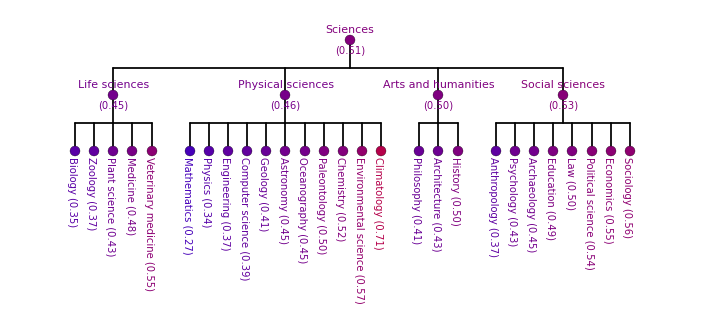

In [67]:
plt.figure(figsize=(12,3));
drawTree(D_com,0,0,0,2);
#drawTree(D_loc,D_loc.vs.find('Mathematics').index,0,0,4);
plt.axis('off');
#plt.savefig('disciplines_loc.pdf',bbox_inches='tight')

In [372]:
def getDisciplineTree(T,root,depth,title,ideology,lb,ub):
    if T.vs[root]['ci']:
        title.append(T.vs[root]['label']+'..'*depth)
        ideology.append(T.vs[root]['color'][0])
        lb.append(T.vs[root]['ci'][0])
        ub.append(T.vs[root]['ci'][1])
        for child in T.neighbors(root,OUT):
            getDisciplineTree(T,child,depth+1,title,ideology,lb,ub)

def drawCI(T,root,figSize=[8,20],filename=''):
    title=[]
    ideology=[]
    lb=[]
    ub=[]
    getDisciplineTree(T,root,0,title,ideology,lb,ub)

    fig=plt.figure(figsize=figSize)
    ax=fig.add_subplot(111)
    ax.scatter(ideology,-np.arange(len(ideology)),s=60,color=np.vstack([ideology,np.zeros_like(ideology),1-np.array(ideology)]).T)
    ax.errorbar(ideology,-np.arange(len(ideology)),
                 xerr=[np.array(ideology)-np.array(lb),np.array(ub)-np.array(ideology)],
                       linestyle='None',ecolor='gray')
    ax.plot([0.5,0.5],[0,-len(ideology)],'k--')
    plt.yticks(-np.arange(len(ideology)), title,fontsize=10)
    ax.set_xlim([0,1])
    ax.set_ylim([-len(ideology),1])
    plt.tight_layout()
    if filename:
        plt.savefig(filename)

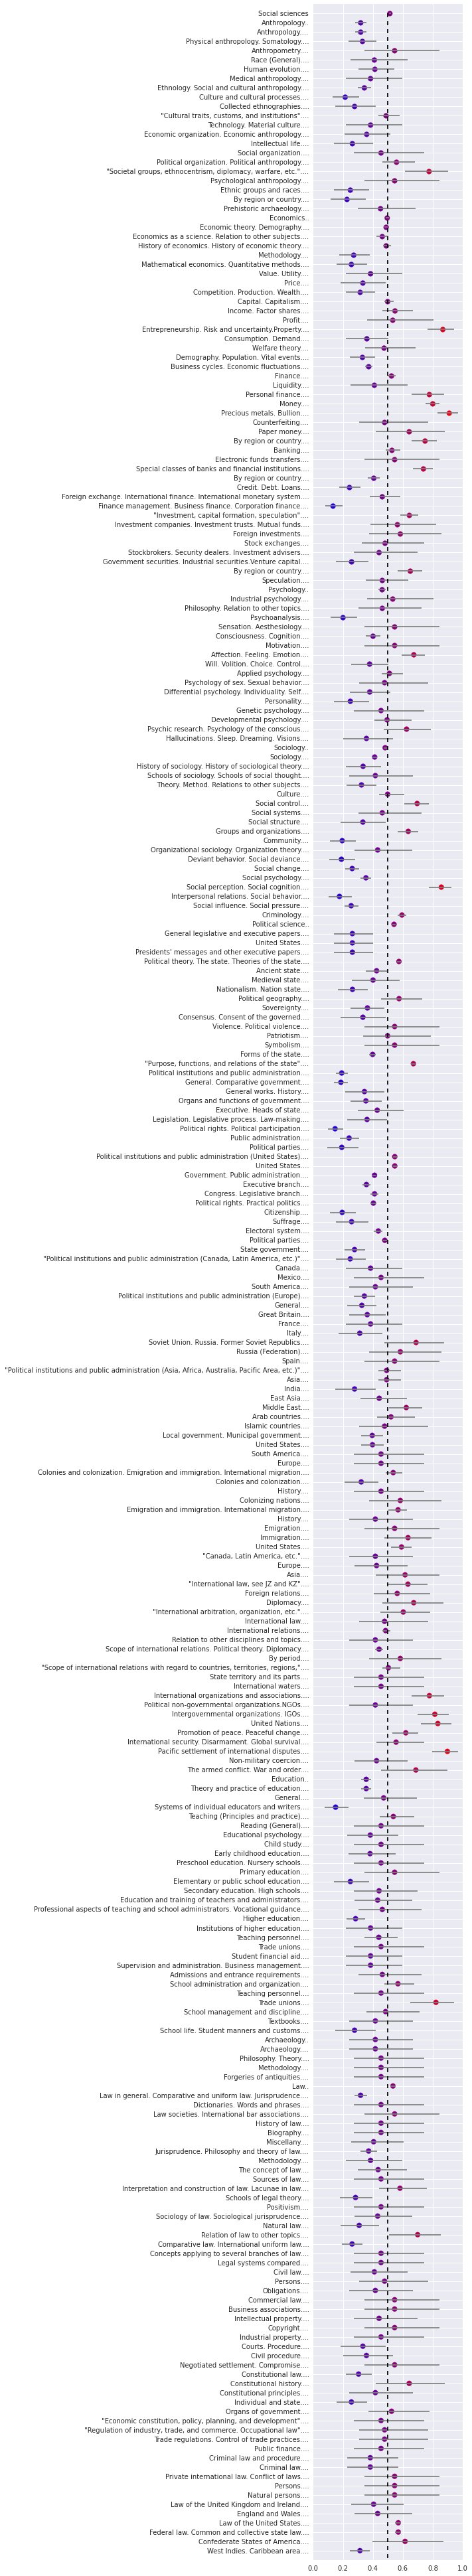

In [395]:
drawCI(D_loc,D_loc.vs.find('Social sciences').index,figSize=[10,54],filename='../Disciplines/socialSciences.pdf')

### Correlations

#### Relevance v.s. Alignment

In [59]:
source = ColumnDataSource(
    data=dict(
        x=[D_loc.vs.find(i['name'])['color'][0] for i in D_int.vs if D_loc.vs.find(i['name'])['relevance']],
        y=np.log([D_loc.vs.find(i['name'])['relevance'] for i in D_int.vs if D_loc.vs.find(i['name'])['relevance']]),
        name=[i['name'] for i in D_int.vs if D_loc.vs.find(i['name'])['relevance']]

    )
)

print "Pearson correlation:{}".format(stats.pearsonr(source.data['x'],source.data['y']))

fig = figure(plot_height=400,x_axis_label="alignment", y_axis_label="relevance",tools=TOOLS,toolbar_location="right")
p=fig.scatter('x','y',size=10,source=source)
hover=p.select(dict(type=HoverTool))
hover.tooltips = '<div><span style="font-size: 15px;">@name</span></div>'
show(p)

Pearson correlation:(0.63962257947148804, 0.00032778757491178979)


#### Polarization v.s. Alignment

In [63]:
source = ColumnDataSource(
    data=dict(
        x=[D_loc.vs.find(i['name'])['color'][0] for i in D_int.vs],
        y=[D_loc.vs.find(i['name'])['polarization'] for i in D_int.vs],
        name=D_int.vs['name']
    )
)

print "Pearson correlation:{}".format(stats.pearsonr(source.data['x'],source.data['y']))

fig = figure(plot_height=400,x_axis_label="alignment", y_axis_label="polarization",tools=TOOLS+',box_zoom',toolbar_location="right")
p=fig.scatter('x','y',size=10,source=source)
hover=p.select(dict(type=HoverTool))
hover.tooltips = '<div><span style="font-size: 15px;">@name</span></div>'
show(p)

Pearson correlation:(0.057901612254762765, 0.75293351692604016)


#### Relevance v.s. Polarization

In [65]:
source = ColumnDataSource(
    data=dict(
        x=[D_loc.vs.find(i['name'])['polarization'] for i in D_int.vs if D_loc.vs.find(i['name'])['relevance']],
        y=np.log([D_loc.vs.find(i['name'])['relevance'] for i in D_int.vs if D_loc.vs.find(i['name'])['relevance']]),
        name=[i['name'] for i in D_int.vs if D_loc.vs.find(i['name'])['relevance']]

    )
)

print "Pearson correlation:{}".format(stats.pearsonr(source.data['x'],source.data['y']))

fig = figure(plot_height=400,x_axis_label="polarization", y_axis_label="relevance",tools=TOOLS+',box_zoom',toolbar_location="right")
p=fig.scatter('x','y',size=10,source=source)
hover=p.select(dict(type=HoverTool))
hover.tooltips = '<div><span style="font-size: 15px;">@name</span></div>'
show(p)

Pearson correlation:(0.27241551268213099, 0.16922577758013746)


In [233]:
def booksInDiscipline(discipline, system='combine', save=False):
    bookTitle=dict()
    bookIdeology=dict()
    if system=='combine':
        tree=isbn2disciplineCom
    elif system=='dd':
        tree=isbn2disciplineDD
    elif system=='loc':
        tree=isbn2disciplineLOC
    else:
        print "No such classification system! Possible choices are 'dd', 'loc', 'combine'."
    for isbn in tree:
        if discipline in tree[isbn]['discipline']:
            bookTitle[isbn]=g.vs[asin2id[isbn]]['title']
            bookIdeology[isbn]=g.vs[asin2id[isbn]]['color'][0]
    df=pd.DataFrame({'asin':bookTitle.keys(),'title':bookTitle.values(),'ideology':[bookIdeology[i] for i in bookTitle]},
                    columns=['title','ideology','asin'], index=None)
    df=df[df.ideology>0]
    pd.set_option('display.max_colwidth',90)
    print df.sort('ideology').to_string(index=False)
    if save:
        df.sort('ideology').to_csv('../Disciplines/'+discipline+'_books_'+system+'.tsv',sep='\t',index=False)

In [ ]:
booksInDiscipline("Environmental science",'loc',save=True)

In [171]:
Counter([len(x['subdiscipline']) for x in isbn2disciplineLOC.values()])

Counter({1: 359950, 2: 733, 3: 8})

In [172]:
b=sorted(isbn2disciplineDD.items(), key=lambda x: len(x[1]['discipline']), reverse=True)

In [173]:
c=[]
for asin,disc in b:
    if sum(g.vs[asin2id[asin]]['color'])>0:
        c.append((asin,disc))

In [175]:
Counter([len(x['discipline']) for x in zip(*c)[1]])

Counter({1: 12901, 2: 32})

In [102]:
outfile=open("overlappingBooks.tsv",'w')
outfile.write('ASIN/ISBN\tTitle\tDiscipline\n')
for asin,disc in c[:2058]:
    outfile.write('{}\t{}\t'.format(asin,g.vs[asin2id[asin]]['title']))
    for d in disc:
        outfile.write('{},'.format(d))
    outfile.write('\n')
outfile.close()

In [83]:
for asin in ['B000B1AAEE','1452605416','B000B1MRGS','B000AHM240','B003O7ZC1S']:
    for isbn in asin2isbn[asin]:
        if isbn in liberals:
            liberals.remove(isbn)
            conservatives.add(isbn)
            print "{}({}) changed from liberal to conservative!".format(isbn,asin)

0767900391 changed from liberal to conservative!
1452605416 changed from liberal to conservative!
0812922573 changed from liberal to conservative!
0895260867 changed from liberal to conservative!
0813125960 changed from liberal to conservative!


In [84]:
for asin in ['B005UG52D4','B001JNUOCG','B000B293TQ']:
    for isbn in asin2isbn[asin]:
        if isbn in conservatives:
            conservatives.remove(isbn)
            liberals.add(isbn)
            print "{}({}) changed from conservative to liberal!".format(isbn,asin)

0199768404(B005UG52D4) changed from conservative to liberal!
1595580492(B001JNUOCG) changed from conservative to liberal!
0198277873(B000B293TQ) changed from conservative to liberal!
